In [2]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import to_date, col

spark = SparkSession.builder.appName("samples_1").getOrCreate()

Mounted at /content/drive


In [3]:
# Criando o df da base desejada olhando apenas uma parição

df= spark.read.parquet("/content/drive/MyDrive/ingestion/fato_total_risco_trigg/dt_fechamento=2024-10-31")
df.printSchema()
df.show(n=10, truncate=False)
df.createOrReplaceTempView("df")
spark.sql("""
select count(*) from df
""").show(5)

root
 |-- ch_cpf_hash: string (nullable = true)
 |-- vl_qnt_conta: long (nullable = true)
 |-- dt_min_adesao: date (nullable = true)
 |-- dt_max_adesao: date (nullable = true)
 |-- vl_min_limite_aprovado: decimal(7,2) (nullable = true)
 |-- vl_max_limite_aprovado: decimal(7,2) (nullable = true)
 |-- vl_total_limite_aprovado: decimal(38,2) (nullable = true)
 |-- min_saldo_devedor: decimal(38,2) (nullable = true)
 |-- max_saldo_devedor: decimal(38,2) (nullable = true)
 |-- total_saldo_devedor: decimal(38,2) (nullable = true)
 |-- min_dias_atraso: integer (nullable = true)
 |-- max_dias_atraso: integer (nullable = true)

+----------------------------------------------------------------+------------+-------------+-------------+----------------------+----------------------+------------------------+-----------------+-----------------+-------------------+---------------+---------------+
|ch_cpf_hash                                                     |vl_qnt_conta|dt_min_adesao|dt_max_adesao|

In [5]:
df= spark.read.parquet("/content/drive/MyDrive/ingestion/fato_total_risco_trigg/dt_fechamento=2024-09-30")
df.createOrReplaceTempView("df")
spark.sql("""
select count(*) as trigg from df
""").show(5)

df= spark.read.parquet("/content/drive/MyDrive/ingestion/fato_total_risco_uze/dt_fechamento=2024-09-30")
df.createOrReplaceTempView("df")
spark.sql("""
select count(*) as uze from df
""").show(5)

df= spark.read.parquet("/content/drive/MyDrive/ingestion/fato_total_risco_fortbrasil/dt_fechamento=2024-09-30")
df.createOrReplaceTempView("df")
spark.sql("""
select count(*) as fortbrasil from df
""").show(5)

df= spark.read.parquet("/content/drive/MyDrive/ingestion/fato_total_risco_credz/dt_fechamento=2024-09-30")
df.createOrReplaceTempView("df")
spark.sql("""
select count(*) as credz from df
""").show(5)

df= spark.read.parquet("/content/drive/MyDrive/ingestion/fato_total_risco_dm/dt_fechamento=2024-09-30")
df.createOrReplaceTempView("df")
spark.sql("""
select count(*) as dm from df
""").show(5)

+------+
| trigg|
+------+
|225530|
+------+

+-------+
|    uze|
+-------+
|2485972|
+-------+

+----------+
|fortbrasil|
+----------+
|   2760647|
+----------+

+-------+
|  credz|
+-------+
|2221295|
+-------+

+-------+
|     dm|
+-------+
|5796543|
+-------+



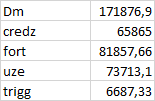

In [8]:
df= spark.read.parquet("/content/drive/MyDrive/ingestion/fato_total_risco_trigg/dt_fechamento=2024-09-30")
df.createOrReplaceTempView("df")
spark.sql("""
select count(*) as trigg from df
""").show(5)

#Realizando o sample
df = df.sample(withReplacement=False, fraction=0.03, seed=42)
df.createOrReplaceTempView("df")
spark.sql("""
select count(*) from df
""").show(5)


+------+
| trigg|
+------+
|225530|
+------+

+--------+
|count(1)|
+--------+
|    6846|
+--------+



In [10]:
cpf_filter = df.select("ch_cpf_hash").distinct().rdd.flatMap(lambda x: x).collect()


In [9]:
from datetime import datetime, timedelta
import calendar
from dateutil.relativedelta import relativedelta

# Data base inicial
dt_fechamento_desejada = datetime.strptime("2024-09-30", "%Y-%m-%d") #Data final desejada

# Gerar os últimos 12 meses com o último dia de cada mês
datas = []
for i in range(4):
    # Subtrair os meses
    nova_data = dt_fechamento_desejada - relativedelta(months=i)
    # Obter o último dia do mês
    last_day = calendar.monthrange(nova_data.year, nova_data.month)[1]
    datas.append(nova_data.replace(day=last_day).strftime("%Y-%m-%d"))

# Exibir os resultados
print(datas)

['2024-09-30', '2024-08-31', '2024-07-31', '2024-06-30']


In [12]:
base_path = "/content/drive/MyDrive/ingestion/fato_total_risco_trigg"
paths = [f"{base_path}/dt_fechamento={data}" for data in datas]
print(paths)

# Ler todas as partições
df_12_meses = spark.read.parquet(*paths)
df.createOrReplaceTempView("df_12_meses")

['/content/drive/MyDrive/ingestion/fato_total_risco_trigg/dt_fechamento=2024-09-30', '/content/drive/MyDrive/ingestion/fato_total_risco_trigg/dt_fechamento=2024-08-31', '/content/drive/MyDrive/ingestion/fato_total_risco_trigg/dt_fechamento=2024-07-31', '/content/drive/MyDrive/ingestion/fato_total_risco_trigg/dt_fechamento=2024-06-30']


In [13]:
# Filtrar o DataFrame de 12 meses pelos CPFs selecionados
df = df_12_meses.filter(df_12_meses["ch_cpf_hash"].isin(cpf_filter))
df.describe().show()

+-------+--------------------+--------------------+----------------------+----------------------+------------------------+------------------+-----------------+-------------------+-----------------+-----------------+
|summary|         ch_cpf_hash|        vl_qnt_conta|vl_min_limite_aprovado|vl_max_limite_aprovado|vl_total_limite_aprovado| min_saldo_devedor|max_saldo_devedor|total_saldo_devedor|  min_dias_atraso|  max_dias_atraso|
+-------+--------------------+--------------------+----------------------+----------------------+------------------------+------------------+-----------------+-------------------+-----------------+-----------------+
|  count|               27384|               27384|                 27384|                 27384|                   27384|             27384|            27384|              27384|            27384|            27384|
|   mean|                NULL|  1.0004382120946538|           2128.162431|           2128.878177|             2131.032720|       1252.23

In [14]:
# Caminho onde você quer salvar o DataFrame no Google Drive
output_path = "/content/drive/MyDrive/ingestion/SOT/tb_risco_trigg_12M"

# Salvar o DataFrame como um arquivo Parquet
df_12_meses.write.parquet(output_path, mode="overwrite")

print(f"DataFrame salvo em: {output_path}")

# Finalizar a sessão do Spark
# spark.stop()

DataFrame salvo em: /content/drive/MyDrive/ingestion/SOT/tb_risco_trigg_12M
